# Proyecto final en Aplicaciones de la linguística computacional

**Clasificación de la ironía de un usuario de twitter**

Aproximación Clasificador BERT, Media, Fully Connected

José Javier Calvo Moratilla

IARFID 2021/2022

In [ ]:
#################################################################
# Librerias
#################################################################
#from google.colab import drive
#drive.mount('/content/gdrive')

import xml.etree.ElementTree as ET
import os
import pandas as pd
import numpy as np

import numpy as np
from sklearn.model_selection import train_test_split
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import numpy as np
from sklearn.model_selection import KFold

from tensorflow.keras.callbacks import ReduceLROnPlateau,  ModelCheckpoint
from keras.callbacks import EarlyStopping

import os
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, InputLayer
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 4.2 MB 10.6 MB/s 
     |████████████████████████████████| 1.2 MB 49.3 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 82.2 MB/s 
     |████████████████████████████████| 6.6 MB 35.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=6dd06527807632a471428a891a49defa1b748071976dd437d7cf1bf76237d6b2
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#################################################################
# Folders
#################################################################
data_folder = "drive/MyDrive/MUIARFID/ALC/data/pan22-author-profiling-training-2022-03-29/en/" 
test_folder = 'drive/MyDrive/MUIARFID/ALC/data/pan22-author-profiling-test-2022-04-22-without_truth/en/'
lib_folder = "drive/MyDrive/MUIARFID/ALC/librerias/"
res_folder = "drive/MyDrive/MUIARFID/ALC/resultados/"
input_folder = "drive/MyDrive/MUIARFID/ALC/"

In [ ]:
#################################################################
# Prepare model model saving directory.
#################################################################
save_dir = os.path.join(os.getcwd(), input_folder + 'saved_models')
name_model = "Irony_image_Model.hdf5"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, name_model)

plot_dir = os.path.join(os.getcwd(), input_folder + 'plot')
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

In [ ]:
#################################################################
# Check point
#################################################################
filepath = input_folder + 'saved_models'

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)

In [ ]:
#################################################################
# Load Data
#################################################################
data = []
id_class = []

num_classes = 2

array_tweets = []
array_clases = []

dict_id_class = {}

# LABELS #######
# 1 = Irony    #
# 0 = No Irony #
################

# Se leen las labels 
with open(data_folder + "truth.txt") as file:
  lines = file.readlines()

  for line in lines:
    id, target = line.split(':::')
    id_class.append([id, target.split('\n')[0]])   
    dict_id_class[id] = 1 if target.split('\n')[0] == 'I' else 0

# Se leen los tuits de cada usuario
for filename in os.listdir(data_folder):

  if(filename == "truth.txt"):
    continue
  
  tree = ET.parse(data_folder + '/' + filename)
  root = tree.getroot()

  author_id = filename.split('.')[0]

  lang = root.attrib['lang']
  
  tweets = []
  for document in root.iter('document'):
    data.append([author_id, lang, document.text])
    tweets.append([document.text])
    array_tweets.append(document.text)
  
  array_clases.append(dict_id_class[author_id])

# Se genera un Dataframe con [author_id, lang, tweet]
col_names = ['author_id', 'lang', 'tweet']
df_data = pd.DataFrame(data, columns=col_names)

# Se genera un Dataframe con [author_id, class]
col_names = ['author_id', 'clase']
df_targets = pd.DataFrame(id_class, columns=col_names)

# Se unen los dos dataframes mediante "author_id" 
df_data= pd.merge(df_data, df_targets, on='author_id', how='outer')
df_data

,author_id,lang,tweet,clase
0,8b73c101dd6e613a0f4dc4b2a784d690,en,The guy is getting away with everything illega...,I
1,8b73c101dd6e613a0f4dc4b2a784d690,en,#USER# #USER# #USER# Wow...I guess his father ...,I
2,8b73c101dd6e613a0f4dc4b2a784d690,en,#USER# #USER# Holy moly...are there 74million ...,I
3,8b73c101dd6e613a0f4dc4b2a784d690,en,Oh how they love to pose and advertise their d...,I
4,8b73c101dd6e613a0f4dc4b2a784d690,en,#USER# Manchin…the Grinch that stole Americans...,I
...,...,...,...,...
83995,79d9dd3cb461aa1ac6ecbeb53545cf7,en,Sunak's cost-of-living plan would hand tax bre...,NI
83996,79d9dd3cb461aa1ac6ecbeb53545cf7,en,Remaining Calm In The Chaos - Trust Yourself T...,NI
83997,79d9dd3cb461aa1ac6ecbeb53545cf7,en,'Real Husbands of Hollywood' with Kevin Hart r...,NI
83998,79d9dd3cb461aa1ac6ecbeb53545cf7,en,▶ Republican Governors Being Taken Down By MAG...,NI


In [ ]:
#################################################################
# Parameters
#################################################################
MAX_SEQUENCE_LENGTH = 128 # 64 o 128
# Standard BERT model with lowercase chars only:
PRETRAINED_MODEL_NAME = 'bert-base-uncased' 
# Batch size for fitting:
BATCH_SIZE = 16 
# Number of epochs:
EPOCHS=200

In [ ]:
#################################################################
# Encoding sentences
#################################################################
sbert_model = SentenceTransformer(PRETRAINED_MODEL_NAME)
data_encoded = sbert_model.encode(array_tweets)

Downloading:   0%|          | 0.00/437 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#################################################################
# Obtain mean of tweets to improve accuracy
#################################################################
data_encoded = np.reshape(data_encoded, (420, 200, -1))
print('Dimensiones de los datos codificados por BERT: ', data_encoded.shape)

y = tf.keras.utils.to_categorical(array_clases, num_classes)
print('Dimensiones de las labels: ', y.shape)

x_media = np.average(data_encoded, axis=1)
print('Dimensiones de la X resultante después de aplicar la media: ', x_media.shape)

Dimensiones de los datos codificados por BERT:  (420, 200, 768)
Dimensiones de las labels:  (420, 2)
Dimensiones de la X resultante después de aplicar la media:  (420, 768)


In [ ]:
#################################################################
# Size of data
#################################################################
x_train, x_test, y_train, y_test = train_test_split(x_media, y, test_size=0.2, random_state=42)
print("X train shape: ", x_train.shape)
print("X test shape: ", x_test.shape)
print("Y train shape: ", y_train.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (336, 768)
X test shape:  (84, 768)
Y train shape:  (336, 2)
Y test shape:  (84, 2)


In [ ]:
#################################################################
# Build the model
#################################################################

def dense_layer(model, units, noise, drop, activation):

  model.add(Dense(units))
  #model.add(BN())
  model.add(GN(noise))
  model.add(Dropout(drop))
  model.add(Activation(activation))

  return model

input_shape = (768,)
num_classes = 2

def build_model(numero):  

  if numero == 1:
    model = Sequential()
    model.add(Dense(256, input_shape=input_shape, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
  elif numero == 2:
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
  
    #model.add(Reshape(target_shape=(153600,), input_shape=ishape))    
    model = dense_layer(model, units=256, noise=0.01, drop=0.1, activation='relu') 
    model = dense_layer(model, units=128, noise=0.01, drop=0.1, activation='relu') 
    model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()

  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 230,018
Trainable params: 230,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
21/21 [==============================] - 3s 14ms/step - loss: 0.6160 - accuracy: 0.6518 - val_loss: 0.4579 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 2/200
21/21 [==============================] - 0s 4ms/step - loss: 0.3998 - accuracy: 0.8571 - val_loss: 0.2675 - val_accuracy: 0.9405 - lr: 0.0010
Epoch

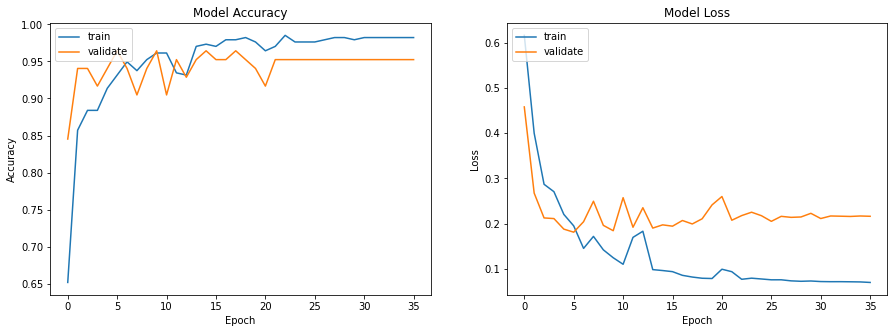

3/3 [==============================] - 0s 4ms/step - loss: 0.1811 - accuracy: 0.9643


[0.1811220794916153, 0.9642857313156128]

In [ ]:
#################################################################
# Train the model
#################################################################

#################################################################
# Build ReduceLROnPlateau
#################################################################
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9)

#################################################################
# Early Stooping:
# Stop training when a monitored metric has stopped improving.
#################################################################

early_stop = EarlyStopping(patience= 30, restore_best_weights=True, monitor="val_accuracy")
STEPS = x_train.shape[0] / BATCH_SIZE
#callbacks = [early_stop, checkpoint, reduce_lr]
callbacks = [early_stop, reduce_lr]

model = build_model(1)

history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(x_test, y_test), callbacks=[callbacks])

#################################################################
# Stats Train
#################################################################

plot_folder = input_folder + 'plot'

fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# summarize history for accuracy
axs[0].plot(history.history['accuracy']) 
axs[0].plot(history.history['val_accuracy']) 
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epoch')
    
axs[0].legend(['train', 'validate'], loc='upper left')
# summarize history for loss
axs[1].plot(history.history['loss']) 
axs[1].plot(history.history['val_loss']) 
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss') 
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'validate'], loc='upper left')
plt.savefig(plot_folder + 'res_image_irony.png')
plt.show()

model.evaluate(x_test, y_test)

In [ ]:
round(model.evaluate(x_test, y_test)[1], 4)

3/3 [==============================] - 0s 4ms/step - loss: 0.1811 - accuracy: 0.9643


0.9643

10 Fold Cross Validation

In [ ]:
'''#################################################################
# K-fold validation
#################################################################
K = 10
l_scores = []
kf = KFold(n_splits=K, random_state=42, shuffle=True)

for train_index, test_index in kf.split(x_media):

  n_samples_train = len(train_index)
  n_samples_test = len(test_index)
  print("Train samples: ", n_samples_train)
  print("Test samples: ", n_samples_test)

  X_train_fold, X_test_fold = x_media[train_index], x_media[test_index]
  y_train_fold, y_test_fold = y[train_index], y[test_index]

  input_shape = (768,)
  num_classes = 2

  model = build_model(1)

  # Configure the model and start training
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=250, verbose=1, validation_data=(X_test_fold, y_test_fold))

  results = model.evaluate(X_test_fold, y_test_fold, batch_size=128)
  print("test loss, test acc:", results)
  l_scores.append(results)

'''

'#################################################################\n# K-fold validation\n#################################################################\nK = 10\nl_scores = []\nkf = KFold(n_splits=K, random_state=42, shuffle=True)\n\nfor train_index, test_index in kf.split(x_media):\n\n  n_samples_train = len(train_index)\n  n_samples_test = len(test_index)\n  print("Train samples: ", n_samples_train)\n  print("Test samples: ", n_samples_test)\n\n  X_train_fold, X_test_fold = x_media[train_index], x_media[test_index]\n  y_train_fold, y_test_fold = y[train_index], y[test_index]\n\n  input_shape = (768,)\n  num_classes = 2\n\n  model = build_model(1)\n\n  # Configure the model and start training\n  model.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n  model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=250, verbose=1, validation_data=(X_test_fold, y_test_fold))\n\n  results = model.evaluate(X_test_fold, y_test_fold, batch_size=128)\n  

In [ ]:
'''l_scores = np.array(l_scores)
l_scores[:, 1]'''

'l_scores = np.array(l_scores)\nl_scores[:, 1]'

In [ ]:
'''print("Media de Acc. sobre test: ", round(np.mean(l_scores[:, 1]), 4))'''

'print("Media de Acc. sobre test: ", round(np.mean(l_scores[:, 1]), 4))'

In [ ]:
#################################################################
# Load Data para
#################################################################
data = []
id_class = []

num_classes = 2

array_tweets = []
array_clases = []

dict_id_class = {}

# LABELS #######
# 1 = Irony    #
# 0 = No Irony #
################

# Se leen los tuits de cada usuario
for filename in os.listdir(test_folder):

  if(filename == "truth.txt"):
    continue
  
  tree = ET.parse(test_folder + filename)
  root = tree.getroot()

  author_id = filename.split('.')[0]

  lang = root.attrib['lang']
  
  tweets = []
  for document in root.iter('document'):
    data.append([author_id, lang, document.text])
    tweets.append([document.text])
    array_tweets.append(document.text)

# Se genera un Dataframe con [author_id, lang, tweet]
col_names = ['author_id', 'lang', 'tweet']
df_data = pd.DataFrame(data, columns=col_names)

# Se genera un Dataframe con [author_id, class]
col_names = ['author_id', 'clase']
df_targets = pd.DataFrame(id_class, columns=col_names)

# Se unen los dos dataframes mediante "author_id" 
df_data= pd.merge(df_data, df_targets, on='author_id', how='outer')
df_data



,author_id,lang,tweet,clase
0,256c393d24578b54e62a704b61e507c0,en,#USER# Maybe this will help you understand the...,NaN
1,256c393d24578b54e62a704b61e507c0,en,#USER# #USER# #USER# #USER# Raises to executiv...,NaN
2,256c393d24578b54e62a704b61e507c0,en,#USER# #USER# How does Trump manage to put his...,NaN
3,256c393d24578b54e62a704b61e507c0,en,#USER# Now????? 2 weeks before the election???...,NaN
4,256c393d24578b54e62a704b61e507c0,en,#USER# Many people will hold you personally re...,NaN
...,...,...,...,...
35995,11af5d73a6168f5d449788d432d3a71c,en,Youngkin Faces new Lawsuit as Virginia Mask Or...,NaN
35996,11af5d73a6168f5d449788d432d3a71c,en,Multiple States Sue Google over ‘Deceptive‘ Lo...,NaN
35997,11af5d73a6168f5d449788d432d3a71c,en,Exclusive — Mike Cernovich: Attempts to ‘Hoax ...,NaN
35998,11af5d73a6168f5d449788d432d3a71c,en,EXCLUSIVE: Lt Gov Mike Kehoe Reportedly Behind...,NaN


In [ ]:
df_data.iloc[0]['author_id']

'256c393d24578b54e62a704b61e507c0'

In [ ]:
#################################################################
# Encoding sentences
#################################################################
sbert_model = SentenceTransformer(PRETRAINED_MODEL_NAME)
data_encoded_test = sbert_model.encode(array_tweets)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#################################################################
# Obtain mean of tweets to improve accuracy
#################################################################
data_encoded_test = np.reshape(data_encoded_test, (180, 200, -1))
print('Dimensiones de los datos codificados por BERT: ', data_encoded.shape)

x_media_test = np.average(data_encoded_test, axis=1)
print('Dimensiones de la X resultante después de aplicar la media: ', x_media.shape)

Dimensiones de los datos codificados por BERT:  (420, 200, 768)
Dimensiones de la X resultante después de aplicar la media:  (420, 768)


In [ ]:
folder_res_test = 'drive/MyDrive/MUIARFID/ALC/resultados/IROSTEO/'

In [ ]:
# Realizar la predicción final

desfalco = 0

resultado_predict = model.predict(x_media_test)

'''
 <author id="author-id"
                    lang="en"
                    type="NI|I"
                    />
'''

res_string = ''

for idx_predict in range(0, 181):  

  if (idx_predict + desfalco) <= 35999:
    
    id_author = df_data.loc[idx_predict + desfalco]['author_id'] 
    #print(id_author)

    predict = ''

    max_predict = np.argmax(resultado_predict[idx_predict])

    if max_predict == 1: #es ironico
      predict = 'I'
    else:
      predict = 'NI'

    res_string = '<author id=\"' +  str(id_author) + '\" lang="en" type=\"' + predict + '\" />'
    
    with open(folder_res_test + str(id_author) + '.xml', 'w') as f:
      f.write(res_string)

    desfalco += 200


In [ ]:
!ls -a 'drive/MyDrive/MUIARFID/ALC/resultados/IROSTEO/' | wc -l

180


In [ ]:
df_data.loc[0]['author_id']


'256c393d24578b54e62a704b61e507c0'

In [ ]:
df_data.loc[200]['author_id']

'a85a9e752b1c7c3e01d300c5e19c6d98'